# Fixed Income Structured Note

This notebook distills the core of the structured note case study.It walks through the market data, valuation setup, and key risk takeaways in a compact narrative.

**Notebook Roadmap**
- Load the  EURIBOR curve and historical fixings.
- Build the discount curve and inspect the term structure.
- Value the capped/floored floating-rate note and summarise cash flows.
- Shock the curve, compute DV01, and back out a hedge ratio versus a plain-vanilla payer swap.

In [1]:
import numpy as np
import pandas as pd
import QuantLib as ql
import matplotlib.pyplot as plt
from pathlib import Path

plt.style.use("seaborn-v0_8-darkgrid")

DATA_DIR = Path("../data")
VALUATION_DATE = ql.Date(26, 11, 2024)
VALUATION_TS = pd.Timestamp("2024-11-26")
ql.Settings.instance().evaluationDate = VALUATION_DATE

curve_df = pd.read_excel(DATA_DIR / "FI.xlsm", sheet_name="Q4", header=2, usecols="E:F").dropna()
curve_df.columns = ["Days", "DiscountFactor"]
curve_df["MaturityDate"] = VALUATION_TS + pd.to_timedelta(curve_df["Days"], unit="D")

historical_df = pd.read_excel(DATA_DIR / "FI.xlsm", sheet_name="Historical Euribor", header=4, usecols="A:B")
historical_df.columns = ["Date", "3M EURIBOR"]
historical_df["Date"] = pd.to_datetime(historical_df["Date"])
historical_df.set_index("Date", inplace=True)
euribor_series = historical_df["3M EURIBOR"].astype(float) / 100

curve_df.head()

,Days,DiscountFactor,MaturityDate
0,0,1.000000,2024-11-26
1,1,0.999917,2024-11-27
2,2,0.999829,2024-11-28
3,3,0.999742,2024-11-29
4,4,0.999656,2024-11-30


## Discount Curve Snapshot

In [2]:
ql_dates = [VALUATION_DATE + int(days) for days in curve_df["Days"]]
discount_curve = ql.DiscountCurve(ql_dates, curve_df["DiscountFactor"].tolist(), ql.Actual365Fixed(), ql.TARGET())
discount_curve.enableExtrapolation()
curve_handle = ql.YieldTermStructureHandle(discount_curve)

curve_df["ZeroRate"] = np.where(
    curve_df["Days"] == 0,
    0.0,
    -np.log(curve_df["DiscountFactor"]) / (curve_df["Days"] / 365)
)
curve_df["ZeroRatePct"] = curve_df["ZeroRate"] * 100

curve_df.tail()

,Days,DiscountFactor,MaturityDate,ZeroRate,ZeroRatePct
21914,21914,0.378624,2084-11-25,0.016177,1.617651
21915,21915,0.378613,2084-11-26,0.016176,1.617628
21916,21916,0.378601,2084-11-27,0.016176,1.617604
21917,21917,0.378590,2084-11-28,0.016176,1.617581
21918,21918,0.378578,2084-11-29,0.016176,1.617557


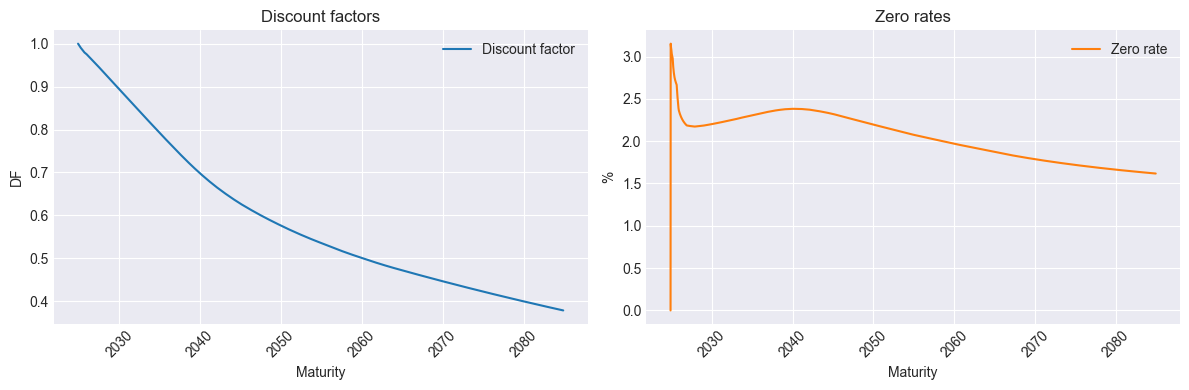

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(curve_df["MaturityDate"], curve_df["DiscountFactor"], label="Discount factor")
axes[0].set_title("Discount factors")
axes[0].set_ylabel("DF")
axes[0].tick_params(axis='x', rotation=45)

axes[1].plot(curve_df["MaturityDate"], curve_df["ZeroRatePct"], color="tab:orange", label="Zero rate")
axes[1].set_title("Zero rates")
axes[1].set_ylabel("%")
axes[1].tick_params(axis='x', rotation=45)

for ax in axes:
    ax.set_xlabel("Maturity")
    ax.legend()

fig.tight_layout()
plt.show()

## Structured Note Valuation

In [4]:
NOTIONAL = 1_000
ISSUE_DATE = ql.Date(29, 7, 2022)
MATURITY_DATE = ql.Date(29, 7, 2027)
SCHEDULE = ql.Schedule(
    ISSUE_DATE,
    MATURITY_DATE,
    ql.Period("3M"),
    ql.TARGET(),
    ql.ModifiedFollowing,
    ql.ModifiedFollowing,
    ql.DateGeneration.Forward,
    False,
)
FLOOR_RATE = 0.016
CAP_RATE = 0.037
DAY_COUNT = ql.Actual360()
CALENDAR = ql.TARGET()


def ql_to_timestamp(qdate: ql.Date) -> pd.Timestamp:
    return pd.Timestamp(qdate.year(), qdate.month(), qdate.dayOfMonth())


def build_cashflows(handle: ql.YieldTermStructureHandle):
    rows = []
    accrued_interest = 0.0

    for i in range(1, len(SCHEDULE)):
        start = SCHEDULE[i - 1]
        end = SCHEDULE[i]
        reset = CALENDAR.advance(start, -2, ql.Days)
        accrual = DAY_COUNT.yearFraction(start, end)

        reset_ts = ql_to_timestamp(reset)
        try:
            ref_rate = euribor_series.loc[reset_ts]
        except KeyError:
            ref_rate = handle.forwardRate(start, end, DAY_COUNT, ql.Simple).rate()

        capped_rate = min(max(ref_rate, FLOOR_RATE), CAP_RATE)
        coupon = NOTIONAL * ref_rate * accrual
        capped_coupon = NOTIONAL * capped_rate * accrual
        df = 1.0 if end <= VALUATION_DATE else handle.discount(end)
        pv = float(df) * coupon
        pv_capped = float(df) * capped_coupon
        include = ql_to_timestamp(end) > VALUATION_TS

        rows.append(
            {
                "Start": ql_to_timestamp(start),
                "End": ql_to_timestamp(end),
                "Reset": reset_ts,
                "Accrual": round(accrual, 6),
                "Euribor Rate (%)": round(ref_rate * 100, 4),
                "Cap/Floor Rate (%)": round(capped_rate * 100, 4),
                "Coupon (€)": round(coupon, 2),
                "Cap/Floor Coupon (€)": round(capped_coupon, 2),
                "DiscountFactor": round(float(df), 6),
                "PV (€)": round(pv, 2),
                "PV Cap/Floor (€)": round(pv_capped, 2),
                "Include": include,
            }
        )

        start_ts = ql_to_timestamp(start)
        end_ts = ql_to_timestamp(end)
        if start_ts <= VALUATION_TS < end_ts:
            accrued_days = (VALUATION_TS - start_ts).days
            accrued_interest = NOTIONAL * capped_rate * accrued_days / 360

    cashflows = pd.DataFrame(rows)
    return cashflows, accrued_interest


def price_note(handle: ql.YieldTermStructureHandle):
    cashflows, accrued_interest = build_cashflows(handle)
    future_cf = cashflows[cashflows["Include"]].copy()
    pv_coupons = future_cf["PV Cap/Floor (€)"].sum()
    pv_notional = NOTIONAL * float(handle.discount(SCHEDULE[-1]))
    gross = pv_coupons + pv_notional
    clean = gross - accrued_interest
    return cashflows, accrued_interest, gross, clean


cashflows, accrued_interest, gross_price, clean_price = price_note(curve_handle)

cashflows[cashflows["Include"]].head()

,Start,End,Reset,Accrual,Euribor Rate (%),Cap/Floor Rate (%),Coupon (€),Cap/Floor Coupon (€),DiscountFactor,PV (€),PV Cap/Floor (€),Include
9,2024-10-29,2025-01-29,2024-10-25,0.255556,3.0590,3.0590,7.82,7.82,0.994724,7.78,7.78,True
10,2025-01-29,2025-04-29,2025-01-27,0.250000,2.6410,2.6410,6.60,6.60,0.988269,6.53,6.53,True
11,2025-04-29,2025-07-29,2025-04-25,0.252778,2.4804,2.4804,6.27,6.27,0.982112,6.16,6.16,True
12,2025-07-29,2025-10-29,2025-07-25,0.255556,1.7927,1.7927,4.58,4.58,0.977633,4.48,4.48,True
13,2025-10-29,2026-01-29,2025-10-27,0.255556,1.8079,1.8079,4.62,4.62,0.973137,4.50,4.50,True


In [5]:
summary = pd.DataFrame(
    {
        "Metric": ["Gross price", "Accrued interest", "Clean price"],
        "Value (€)": [gross_price, accrued_interest, clean_price],
    }
)
summary["Value (€)"] = summary["Value (€)"].round(2)
summary

,Metric,Value (€)
0,Gross price,1002.59
1,Accrued interest,2.38
2,Clean price,1000.21


## Curve Sensitivities and Hedge Ratio

In [6]:
def build_curve_from_dfs(dfs: np.ndarray) -> ql.YieldTermStructureHandle:
    curve = ql.DiscountCurve(ql_dates, dfs.tolist(), ql.Actual365Fixed(), ql.TARGET())
    curve.enableExtrapolation()
    return ql.YieldTermStructureHandle(curve)


def price_swap(handle: ql.YieldTermStructureHandle, swap_rate: float = 0.0202, swap_type: str = "payer") -> float:
    valuation_date = VALUATION_DATE
    maturity_date = ql.Date(26, 11, 2027)

    fixed_schedule = ql.Schedule(
        valuation_date,
        maturity_date,
        ql.Period("1Y"),
        ql.TARGET(),
        ql.ModifiedFollowing,
        ql.ModifiedFollowing,
        ql.DateGeneration.Backward,
        False,
    )
    floating_schedule = ql.Schedule(
        valuation_date,
        maturity_date,
        ql.Period("6M"),
        ql.TARGET(),
        ql.ModifiedFollowing,
        ql.ModifiedFollowing,
        ql.DateGeneration.Backward,
        False,
    )

    dc_float = ql.Actual360()
    dc_fixed = ql.Thirty360(ql.Thirty360.EurobondBasis)

    pv_float = 0.0
    for i in range(1, len(floating_schedule)):
        start = floating_schedule[i - 1]
        end = floating_schedule[i]
        fwd_rate = handle.forwardRate(start, end, dc_float, ql.Simple).rate()
        accrual = dc_float.yearFraction(start, end)
        pv_float += NOTIONAL * fwd_rate * float(handle.discount(end)) * accrual

    pv_fixed = 0.0
    for i in range(1, len(fixed_schedule)):
        start = fixed_schedule[i - 1]
        end = fixed_schedule[i]
        accrual = dc_fixed.yearFraction(start, end)
        pv_fixed += NOTIONAL * swap_rate * float(handle.discount(end)) * accrual

    return pv_float - pv_fixed if swap_type == "payer" else pv_fixed - pv_float


def apply_shift(spot_curve: np.ndarray, shift_type: str, shift: float) -> np.ndarray:
    if shift_type == "parallel":
        return spot_curve + shift
    if shift_type == "slope":
        weights = np.linspace(-0.5, 0.5, len(spot_curve))
        return spot_curve + shift * weights
    if shift_type == "curvature":
        x = np.linspace(-1, 1, len(spot_curve))
        shape = 1 - 2 * x**2
        shape -= shape.mean()
        return spot_curve + shift * shape
    raise ValueError("Unknown shift type")


base_spot = curve_df["ZeroRate"].to_numpy(dtype=float)
days = curve_df["Days"].to_numpy(dtype=float)
basis_point = 1e-4

results = []
for label in ["parallel", "slope", "curvature"]:
    up_rates = apply_shift(base_spot, label, basis_point)
    down_rates = apply_shift(base_spot, label, -basis_point)

    up_rates[0] = 0.0
    down_rates[0] = 0.0

    up_dfs = np.exp(-up_rates * days / 365)
    down_dfs = np.exp(-down_rates * days / 365)
    up_dfs[0] = 1.0
    down_dfs[0] = 1.0

    up_handle = build_curve_from_dfs(up_dfs)
    down_handle = build_curve_from_dfs(down_dfs)

    _, _, up_gross, _ = price_note(up_handle)
    _, _, down_gross, _ = price_note(down_handle)
    note_dv01 = -(up_gross - down_gross) / 2

    up_swap = price_swap(up_handle)
    down_swap = price_swap(down_handle)
    swap_dv01 = -(up_swap - down_swap) / 2

    hedge_ratio = 0.0 if abs(swap_dv01) < 1e-8 else -note_dv01 / swap_dv01

    results.append(
        {
            "Shift": label.title(),
            "Note DV01 (€)": note_dv01,
            "Swap DV01 (€)": swap_dv01,
            "Hedge Ratio (swap notional / note notional)": hedge_ratio,
        }
    )

sensitivities = pd.DataFrame(results).round(4)
sensitivities

,Shift,Note DV01 (€),Swap DV01 (€),Hedge Ratio (swap notional / note notional)
0,Parallel,0.0420,-0.2926,0.1437
1,Slope,-0.0198,0.1318,0.1503
2,Curvature,-0.0453,0.2800,0.1619


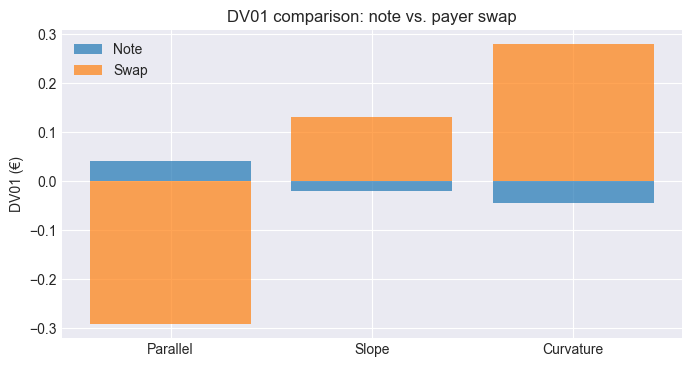

In [7]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.bar(sensitivities["Shift"], sensitivities["Note DV01 (€)"], label="Note", alpha=0.7)
ax.bar(sensitivities["Shift"], sensitivities["Swap DV01 (€)"], label="Swap", alpha=0.7)
ax.set_ylabel("DV01 (€)")
ax.set_title("DV01 comparison: note vs. payer swap")
ax.legend()
plt.show()

### Takeaways
- The structured note carries positive DV01 under parallel curve shifts, so long swaps help neutralise the exposure.
- Slope and curvature shocks matter almost as much as parallel moves; recruiters can probe how you would extend the hedge to multi-factor coverage.
- The analytics here map directly to the more detailed notebooks in this repository for deeper technical walkthroughs.